In [74]:
!pip install torch

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 750.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.7 MB/s eta 0:00:00


In [35]:
import gym
from IPython.display import HTML
import os
from pathlib import Path
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque

In [36]:
# 신경망 정의
class DQN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

In [37]:
# DQN 에이전트 정의
class DQNAgent:
    def __init__(self, state_size, action_size, hidden_size=64, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_size = hidden_size
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 신경망 초기화
        self.policy_net = DQN(state_size, hidden_size, action_size).to(self.device)
        self.target_net = DQN(state_size, hidden_size, action_size).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.memory = deque(maxlen=10000)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).to(self.device)
        q_values = self.policy_net(state)
        return torch.argmax(q_values).item()

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.int64).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(-1).to(self.device)

        current_q_values = self.policy_net(states).gather(1, actions.unsqueeze(1))
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0].unsqueeze(1)
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        loss = F.mse_loss(current_q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def target_update(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def train(self, max_episodes=1000, batch_size=64, target_update_freq=10, print_interval=10):
        scores = []
        episodes = []  # 각 에피소드의 마지막 상태를 저장할 리스트
        for episode in range(max_episodes):
            state = env.reset()
            done = False
            total_reward = 0
            while not done:
                action = self.act(state)
                next_state, reward, done, _ = env.step(action)
                total_reward += reward
                self.remember(state, action, reward, next_state, done)
                state = next_state
                self.replay(batch_size)
            if episode % target_update_freq == 0:
                self.target_update()
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            scores.append(total_reward)
            if episode % print_interval == 0:
                print("Episode {}: Total Reward = {}".format(episode, total_reward))
                episodes.append(env.render(mode='rgb_array'))  # 에피소드의 마지막 상태를 이미지로 저장
        return scores, episodes

In [38]:
# 카트폴 환경 설정
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [39]:
# 에이전트 생성 및 학습
agent = DQNAgent(state_size, action_size)
scores, episodes = agent.train()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
<ipython-input-37-fc0fd301aa43>:48: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(current_q_values, target_q_values)


Episode 0: Total Reward = 13.0
Episode 10: Total Reward = 18.0
Episode 20: Total Reward = 14.0
Episode 30: Total Reward = 15.0
Episode 40: Total Reward = 16.0
Episode 50: Total Reward = 13.0
Episode 60: Total Reward = 37.0
Episode 70: Total Reward = 47.0
Episode 80: Total Reward = 35.0
Episode 90: Total Reward = 15.0
Episode 100: Total Reward = 79.0
Episode 110: Total Reward = 88.0
Episode 120: Total Reward = 59.0
Episode 130: Total Reward = 48.0
Episode 140: Total Reward = 31.0
Episode 150: Total Reward = 264.0
Episode 160: Total Reward = 154.0
Episode 170: Total Reward = 35.0
Episode 180: Total Reward = 273.0
Episode 190: Total Reward = 223.0
Episode 200: Total Reward = 23.0
Episode 210: Total Reward = 269.0
Episode 220: Total Reward = 212.0
Episode 230: Total Reward = 63.0
Episode 240: Total Reward = 278.0
Episode 250: Total Reward = 334.0
Episode 260: Total Reward = 283.0
Episode 270: Total Reward = 280.0
Episode 280: Total Reward = 299.0
Episode 290: Total Reward = 242.0
Episode 3

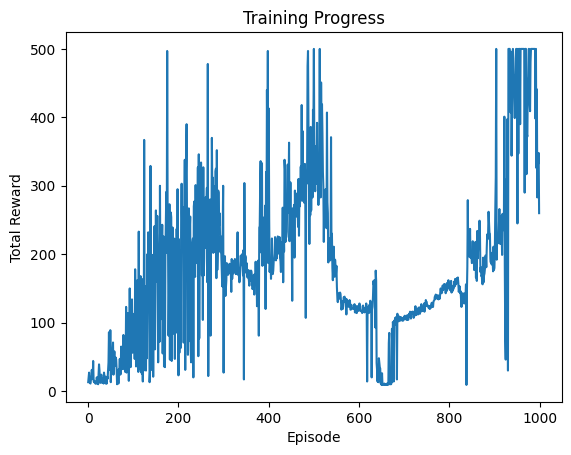

In [40]:
# 결과 출력
import matplotlib.pyplot as plt
plt.plot(scores)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.show()